## Intro

In [ ]:
!curl -O http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/reviews_Clothing_Shoes_and_Jewelry_5.json.gz
!ls

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 45.0M  100 45.0M    0     0  13.2M      0  0:00:03  0:00:03 --:--:-- 13.2M
reviews_Clothing_Shoes_and_Jewelry_5.json.gz  sample_data


In [4]:
import gzip
import json
import numpy as np
import nltk
from tqdm import tqdm
import string
import sklearn
import sklearn.decomposition
import sklearn.naive_bayes
import sklearn.ensemble
import sklearn.svm
import sklearn.neighbors
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import itertools
from google.colab import drive
drive.mount('/content/drive/')
savepath = '/content/drive/My Drive/Colab Notebooks/TMS/Results/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/biocreative_ppi.zip.
[nltk_data]    | Downloading package brown to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown.zip.
[nltk_data]    | Downloading package brown_tei to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/brown_tei.zip.
[nltk_data]    | Downloading package cess_cat to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_cat.zip.
[nltk_data]    | Downloading package cess_esp to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cess_esp.zip.
[nltk_data]    | Downloading package chat80 to /root/nltk_data...
[nltk_data]    |   Unzipp

True

In [5]:
filename = 'reviews_Clothing_Shoes_and_Jewelry_5.json.gz'
if filename.endswith('gz'):
    file_reader = gzip.open(filename, 'r')
    reviews = [json.loads(review.decode('utf-8')) for review in file_reader]
else:
    with open(filename, 'r') as f:
        reviews = [json.loads(review) for review in f.readlines()]
#reviews = reviews[:1000]
scores = [review['overall'] for review in reviews]
scores = np.array(scores)
reviews = [review['reviewText'] for review in reviews]

The problem we want to solve is a binary classification one (positive and negative reviews). In order to do this we aggregate 1 and 2 stars reviews into the 'negative' category and the 4-5 start into the 'positive'.

The 'neutral' 3 stars are discared.

In [6]:
neg = np.where(scores < 3.0)[0]
pos = np.where(scores > 3.0)[0]
not_neu = np.where(scores != 3.0)[0]
scores[neg] = 0
scores[pos] = 1
scores = scores[not_neu]
new_docs = list()
for i in not_neu:
    new_docs.append(reviews[i])
reviews = new_docs
del neg, pos, not_neu, new_docs

## NLP

In [7]:
print('Tokenizing:')
tokenized_docs = list()
for review in tqdm(reviews):
    tokenized_docs.append(nltk.tokenize.word_tokenize(review))
reviews = tokenized_docs
del tokenized_docs

  0%|          | 57/248252 [00:00<07:17, 567.71it/s]

Tokenizing:


100%|██████████| 248252/248252 [02:18<00:00, 1786.66it/s]


In [8]:
print('Removing stop words:')
stop_words = set(nltk.corpus.stopwords.words('english'))    
modified_docs = list()
for doc in tqdm(reviews):
    modified_docs.append(list())
    for token in doc:
        if token not in stop_words:
            modified_docs[-1].append(token)
reviews = modified_docs
del modified_docs

  3%|▎         | 6431/248252 [00:00<00:03, 64303.16it/s]

Removing stop words:


100%|██████████| 248252/248252 [00:05<00:00, 48655.35it/s]


In [9]:
print('Lemmatizing:')
def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts

    Parameters
    ----------
    word : str
        Word to tag.

    Returns
    -------
    tag : str
        The word neg tag.

    """
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": nltk.corpus.wordnet.ADJ,
                "N": nltk.corpus.wordnet.NOUN,
                "V": nltk.corpus.wordnet.VERB,
                "R": nltk.corpus.wordnet.ADV}

    return tag_dict.get(tag, nltk.wordnet.NOUN)
wnl = nltk.stem.WordNetLemmatizer()
lemmatized_docs = list()
for doc in tqdm(reviews):
    lemmatized_docs.append(list())
    for token in doc:
        pos = get_wordnet_pos(token)
        lemmatized_docs[-1].append(wnl.lemmatize(token, pos))
reviews = lemmatized_docs
del lemmatized_docs

  0%|          | 0/248252 [00:00<?, ?it/s]

Lemmatizing:


100%|██████████| 248252/248252 [21:12<00:00, 195.01it/s]


In [10]:
print('Removing punctuation:')
modified_docs = list()
for doc in tqdm(reviews):
    modified_docs.append(list())
    for token in doc:
        if token not in string.punctuation:
            modified_docs[-1].append(token)
    modified_docs[-1] = ' '.join(modified_docs[-1])
reviews = modified_docs
del modified_docs

  4%|▎         | 8814/248252 [00:00<00:02, 88133.15it/s]

Removing punctuation:


100%|██████████| 248252/248252 [00:02<00:00, 90441.42it/s]


In [11]:
print('Building the Tf-idf representation...', end=' .')
vectorizer = sklearn.feature_extraction.text.TfidfVectorizer(lowercase=False)
tfidf = vectorizer.fit_transform(reviews)
print('Done')

Building the Tf-idf representation... .Done


In [12]:
print('Decomposing the Tf-idf matrix... ', end=' .')
n_features = 100
decomposer = sklearn.decomposition.TruncatedSVD(n_features)
dc_tfidf = decomposer.fit_transform(tfidf)
del tfidf
print('Done')

Decomposing the Tf-idf matrix...  .Done


## Model Training

In [13]:
split_data = sklearn.model_selection.train_test_split(dc_tfidf, scores,
                                            test_size=0.2, shuffle=True,
                                            stratify=scores)
del dc_tfidf
train_x, test_x, train_y, test_y = split_data

In [14]:
# count class occurences
classes, counts = np.unique(train_y, return_counts=True)
ind = np.argsort(classes)
classes = classes[ind]
counts = counts[ind]
# print class occurences
df = pd.DataFrame({'Class': classes, 'Counts': counts,
                    'Rel Counts (%)': 100*counts/counts.sum()})
df = df.T
print(df)
# find sample weights
sample_weights = 1/counts
sample_weights = sample_weights / sample_weights.sum()
sample_weights = sample_weights[np.where(
    train_y.reshape(train_y.size, 1) == classes[np.newaxis, :])[1]]

                           0              1
Class               0.000000       1.000000
Counts          21324.000000  177277.000000
Rel Counts (%)     10.737106      89.262894


In [15]:
def train_and_evaluate(classifier, split_data, sample_weights, name,
                       results_path):
    """Trains and evaluates a sklearn classifier. The confusion matrix is
    saved to file and show both in textual and graphical format.

    Parameters
    ----------
    classifier : sklearn classifier
        An instance of a sklearn classifier sutiable for the task.
    split_data : tuple
        Tuple consisting of train_x, test_x, train_y, test_y.
    sample_weights : np 1D array
        Array of the same size of train_x and train_y. Used to get a balanced
        fit out of an unbalanced dataset. Doesn't make sense on some algorithms.
    name : str
        Model name. Used in the reports.
    results_path : str
        Path showing where to save the results.

    Returns
    -------
    classifier : sklearn classifier
        The trained sklearn classifier.
    cm : matrix
        The confusion matrix of the model. The axes follow the sklearn
        convention (ture labels on the first, predicted on the second).
    """
    print('Training the classifier... ', end=' .')
    train_x, test_x, train_y, test_y = split_data
    if sample_weights is not None:
        classifier.fit(train_x, train_y, sample_weights)
    else:
        classifier.fit(train_x, train_y)
    print('Done')
    estimates = classifier.predict(test_x)
    print('Building the confusion matrix...', end=' .')
    cm = sklearn.metrics.confusion_matrix(test_y, estimates, labels=[0.0, 1.0])
    cr = sklearn.metrics.classification_report(test_y, estimates)
    with open(results_path + name + ' Classification Report.txt', 'w') as f:
        f.write(cr)
    print('Done')
    fig, ax = plt.subplots()
    sklearn.metrics.plot_confusion_matrix(classifier, test_x, test_y,
                                          labels=[0.0, 1.0], ax=ax)
    ax.set_title(name + ' Confusion Matrix')
    fig.savefig(results_path + '{} Confusion Matrix.pdf'.format(name))
    print(cr)
    fig.show()
    return classifier, cm

Training the classifier...  .Done
Building the confusion matrix... .Done
              precision    recall  f1-score   support

         0.0       0.18      0.74      0.28      5331
         1.0       0.95      0.58      0.72     44320

    accuracy                           0.60     49651
   macro avg       0.56      0.66      0.50     49651
weighted avg       0.87      0.60      0.67     49651



(GaussianNB(priors=None, var_smoothing=1e-09), array([[ 3942,  1389],
        [18509, 25811]]))

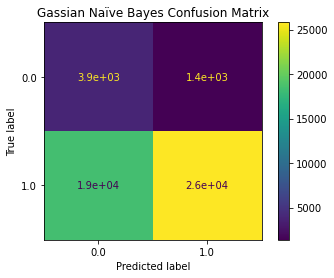

In [ ]:
# Naive Bayes
train_and_evaluate(sklearn.naive_bayes.GaussianNB(), split_data, sample_weights,
                   'Gassian Naïve Bayes', savepath)

Training the classifier...  .Done
Building the confusion matrix... .Done
              precision    recall  f1-score   support

         0.0       0.75      0.10      0.18      5331
         1.0       0.90      1.00      0.95     44320

    accuracy                           0.90     49651
   macro avg       0.82      0.55      0.56     49651
weighted avg       0.89      0.90      0.86     49651



(RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                        criterion='gini', max_depth=None, max_features='auto',
                        max_leaf_nodes=None, max_samples=None,
                        min_impurity_decrease=0.0, min_impurity_split=None,
                        min_samples_leaf=1, min_samples_split=2,
                        min_weight_fraction_leaf=0.0, n_estimators=100,
                        n_jobs=None, oob_score=False, random_state=None,
                        verbose=0, warm_start=False), array([[  539,  4792],
        [  182, 44138]]))

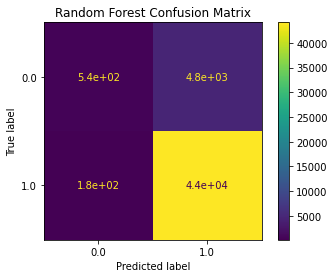

In [ ]:
# Random Forest
train_and_evaluate(sklearn.ensemble.RandomForestClassifier(), split_data,
                   sample_weights, 'Random Forest', savepath)

Training the classifier...  .Done
Building the confusion matrix... .Done
              precision    recall  f1-score   support

         0.0       0.32      0.84      0.46      5331
         1.0       0.98      0.79      0.87     44320

    accuracy                           0.79     49651
   macro avg       0.65      0.81      0.67     49651
weighted avg       0.91      0.79      0.83     49651



(LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
           intercept_scaling=1, loss='squared_hinge', max_iter=1000,
           multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
           verbose=0), array([[ 4452,   879],
        [ 9376, 34944]]))

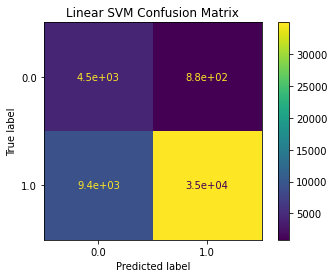

In [ ]:
# Linear SVM
train_and_evaluate(sklearn.svm.LinearSVC(), split_data,
                   sample_weights, 'Linear SVM', savepath)

Neural Network

In [16]:
class_weights = 1/counts
class_weights = class_weights / class_weights.sum()
class_weights = dict(zip(classes, class_weights))
train_y = keras.utils.to_categorical(train_y)
test_y = keras.utils.to_categorical(test_y)

def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [17]:
classifier = keras.models.Sequential()
classifier.add(keras.layers.Dense(512, activation='relu',
                                  input_shape=(n_features,)))
classifier.add(keras.layers.Dense(128, activation='relu'))
classifier.add(keras.layers.Dense(2, activation='softmax'))
classifier.compile(loss='binary_crossentropy')
classifier.fit(train_x, train_y, class_weight=class_weights, batch_size=32,
               epochs=5)

Epoch 1/5
6207/6207 [==============================] - 16s 3ms/step - loss: 0.0802
Epoch 2/5
6207/6207 [==============================] - 16s 3ms/step - loss: 0.0772
Epoch 3/5
6207/6207 [==============================] - 16s 3ms/step - loss: 0.0772
Epoch 4/5
6207/6207 [==============================] - 15s 2ms/step - loss: 0.0753
Epoch 5/5
6207/6207 [==============================] - 16s 3ms/step - loss: 0.0743


Building the confusion matrix... .Done
[[ 4369   962]
 [ 7461 36859]]


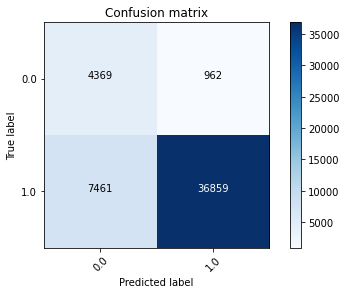

In [20]:
estimates = classifier.predict(test_x)
estimates = np.argmax(estimates, axis=1)
test_y = np.argmax(test_y, axis=1)
print('Building the confusion matrix...', end=' .')
cm = sklearn.metrics.confusion_matrix(test_y, estimates, labels=[0.0, 1.0])
cr = sklearn.metrics.classification_report(test_y, estimates)
with open(savepath + 'ANN Classification Report.txt', 'w') as f:
    f.write(cr)
print('Done')
plot_confusion_matrix(cm, [0.0, 1.0])
plt.savefig(savepath + 'ANN Confusion Matrix.pdf')